# Estimator로 선형 모델 만들기
- `tf.estimator` API를 사용하여 <i>logistic regression model</i>을 훈련


## 1. 설정

In [2]:
!pip install -q sklearn

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

## 2. 타이타닉 데이터셋 불러오기
- 성별, 나이, 클래스, 기타 등 주어진 정보를 활용하여 승객이 살아남을 것인지 예측하는 모델

In [4]:
import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

# 데이터셋 불러오기.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

## 3. 데이터 요약
|Feature Name|Description|
|---|---|
|sex|Gender of passenger|
|age|Age of passenger|
|n_siblings_spouses|siblings and partners aboard|
|parch|of parents and children aboard|
|fare|Fare passenger paid|
|class|Passenger's class on ship|
|deck|Which deck passenger was on|
|embark_town|Which town passenger embarked from|
|alone|If passenger was alone|

In [5]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [6]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


- train set은 627개의 샘플
- test set은 264개의 샘플

In [7]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

- 20대와 30대가 대부분의 승객

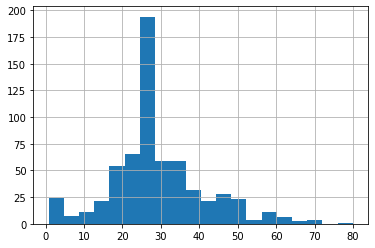

In [8]:
dftrain.age.hist(bins=20)

- 남자 승객과 여자 승객 비교

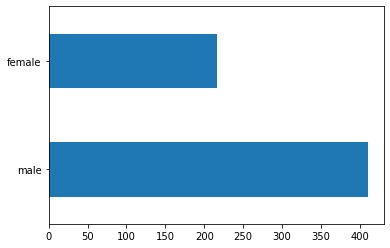

In [9]:
dftrain.sex.value_counts().plot(kind='barh')

- 대부분의 승객은 third class

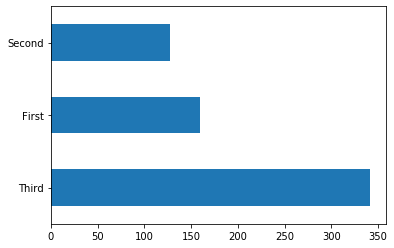

In [10]:
dftrain['class'].value_counts().plot(kind='barh')

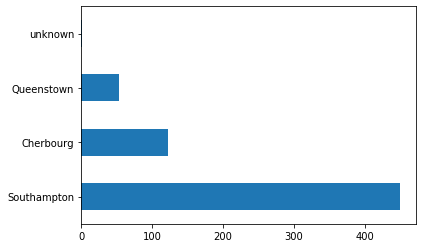

In [11]:
dftrain.embark_town.value_counts().plot(kind='barh')

---
- 여자가 남자보다 살아남을 확률이 훨씬 높음(유용한 특성)

Text(0.5, 0, '% survive')

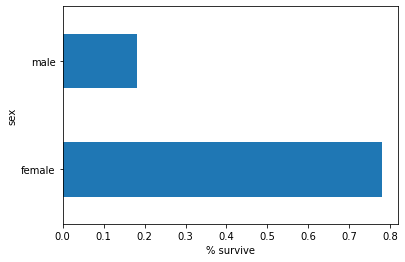

In [12]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

## 4. 모델을 위한 feature engineering
- 모델 학습을 효과적으로 하기 위해 feature column을 고르고 다듬어야 함
- one-hot-encoding, normalization, bucketization과 같은 feature engineering을 사용

### Basin feature column

In [13]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique() # 유일한 값을 세어줌
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

- `tf.data.Dataset`은 데이터 프레임, CSV형식 파일 등과 같은 여러 소스를 사용할 수 있으며 `input_function`을 통해 `tf.data.Dataset`으로 변환

In [14]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [15]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
  print('특성 키:', list(feature_batch.keys()))
  print()
  print('클래스 배치:', feature_batch['class'].numpy())
  print()
  print('레이블 배치:', label_batch.numpy())

특성 키: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

클래스 배치: [b'First' b'Third' b'First' b'First' b'Third' b'Second' b'First' b'First'
 b'Third' b'First']

레이블 배치: [0 0 1 1 0 1 0 1 0 0]


In [16]:
# tf.keras.layers.DenseFeatures를 사용하면 특정 feature column의 결과를 볼 수 있음
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[65.],
       [28.],
       [27.],
       [52.],
       [32.],
       [18.],
       [28.],
       [22.],
       [48.],
       [56.]], dtype=float32)

In [17]:
# 모든 기본 특성을 추가한 뒤 모델 훈련
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.75757575, 'accuracy_baseline': 0.625, 'auc': 0.83302724, 'auc_precision_recall': 0.7911085, 'average_loss': 0.47307688, 'label/mean': 0.375, 'loss': 0.46465477, 'precision': 0.68817204, 'prediction/mean': 0.37115765, 'recall': 0.64646465, 'global_step': 200}


### 도출된 feature column
- 각 기본 feature column만으로 데이터를 설명하기 충분하지 않음
- 몇 가지 feature들을 cross<u>(교차 특성 열 추가)</u>
  - 예: gender = "Male" 과 age = "30"

In [18]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)

In [19]:
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7765151, 'accuracy_baseline': 0.625, 'auc': 0.84912765, 'auc_precision_recall': 0.78795046, 'average_loss': 0.4677355, 'label/mean': 0.375, 'loss': 0.4574672, 'precision': 0.73255813, 'prediction/mean': 0.3494181, 'recall': 0.6363636, 'global_step': 200}


- 단일 특성만을 사용한 것 보다 성능이 향상됨을 볼 수 있음
---

### 예측

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/d2/022kv381389119qk02mlv7s80000gn/T/tmp_d9losyp/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_te

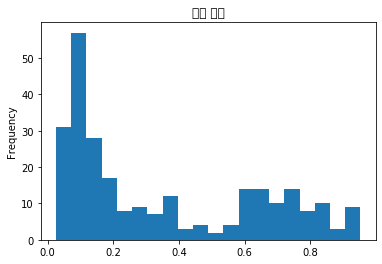

In [20]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='예측 확률')

- ROC(receiver operating characteristic) 그래프를 통해 true positive rate, false positive rate의 상충관계 파악 가능

(0, 1.05)

/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 53456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 53456 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text

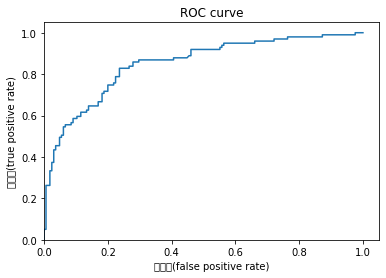

In [21]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('오탐률(false positive rate)')
plt.ylabel('정탐률(true positive rate)')
plt.xlim(0,)
plt.ylim(0,)